# Comparative Analysis Against the Standalone Models

## Read the Data

In [1]:
import os
import pandas as pd


datamatrixDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/final/data_matrix.csv''')
datamatrixDf

,person_id,visit_occurrence_id,measurement_date,visit_start_date_adm,death_adm,vitals_systemic_mean_avg,vitals_systemic_diastolic_avg,vitals_systemic_systolic_avg,vitals_respiration_avg,vitals_heartrate_avg,...,labs_Red blood cell count_last,labs_Calcium level_last,labs_MCV - Mean corpuscular volume_last,labs_MCHC - Mean corpuscular haemoglobin concentration_last,labs_MCH - Mean corpuscular haemoglobin_last,labs_White blood cell count_last,labs_Red blood cell distribution width_last,labs_Glucose level_last,labs_Bicarbonate level_last,labs_Anion gap_last
0,248364,141515,2014-04-04,2014-04-04,0,65.344086,47.924731,105.265233,25.763066,89.777003,...,4.37,9.5,90.4,34.9,31.6,3.8,15.5,97.0,21.0,19.0
1,248364,141515,2014-04-05,2014-04-04,0,68.147368,51.291228,99.049123,23.763889,101.937500,...,3.29,7.6,92.1,34.3,31.6,10.0,16.7,154.0,21.0,14.0
2,248364,141515,2014-04-06,2014-04-04,0,78.180556,57.565972,111.343750,23.731707,109.117021,...,3.34,7.9,91.6,33.7,30.8,12.9,17.3,105.0,22.0,13.0
3,248364,141515,2014-04-07,2014-04-04,0,82.724739,57.696864,123.606272,33.772727,79.000000,...,3.14,8.2,91.4,33.8,30.9,11.7,17.0,123.0,22.0,12.0
4,248364,141515,2014-04-08,2014-04-04,0,75.000000,53.103306,114.359504,30.335664,81.479021,...,2.86,8.0,95.1,33.1,31.5,9.9,17.2,116.0,22.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56232,3521842,3352884,2014-01-29,2014-01-28,0,89.946929,66.934130,137.592436,19.909722,100.312500,...,3.37,8.1,92.0,35.0,32.0,14.4,13.7,62.0,19.0,6.0
56233,3521842,3352884,2014-01-30,2014-01-28,0,73.849266,50.696327,127.106241,21.030612,82.459184,...,3.32,7.8,92.0,35.0,33.0,11.4,14.1,98.0,21.0,3.0
56234,358073,3352922,2015-06-02,2015-06-01,0,78.000000,64.023256,97.302326,17.929821,77.197917,...,4.10,8.0,88.0,33.0,29.0,8.7,17.5,143.0,25.0,7.0
56235,358073,3352922,2015-06-03,2015-06-01,0,106.010242,78.054524,160.937190,19.117647,97.704861,...,3.80,8.5,87.0,33.0,29.0,6.9,17.4,159.0,25.0,7.0


## A Function to Calculate MCC-F1 Score

In [ ]:
def calculateMccF1(x, y):
    import sys
    import os

    import rpy2.robjects as robjects
    from rpy2.robjects.packages import importr

    # import R's "base" package
    mccf1 = importr('mccf1')

    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    p = robjects.FloatVector(x)
    t = robjects.FloatVector(y)
    calculateMccf1 = robjects.r['mccf1']
    summary = robjects.r['summary']
    out = summary(calculateMccf1(t, p), 50)[0][0]
    sys.stdout = old_stdout # reset old stdout
    return out

## Standalone XGB Model

In [2]:
def getBestXgbHyperparameter(X, y, tuned_params, parameters):

    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV

    params = {}

    print('Hyperparameter optimisation for: ' + str(parameters))

    clf = GridSearchCV(XGBClassifier(use_label_encoder=False, **tuned_params), parameters)
    clf.fit(X, y)

    params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]

    return(params)


def performXgbHyperparameterTuning(X, y):

    params = {}

    params.update(getBestXgbHyperparameter(X, y, params, {'max_depth' : range(1,10),'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],}))

    params.update(getBestXgbHyperparameter(X, y, params, {'n_estimators':range(50,250,10)}))

    params.update(getBestXgbHyperparameter(X, y, params, {'min_child_weight':range(1,10)}))

    params.update(getBestXgbHyperparameter(X, y, params, {'gamma':[i/10. for i in range(0,5)]}))

    params.update(getBestXgbHyperparameter(X, y, params, {'subsample':[i/10.0 for i in range(1,10)],'colsample_bytree':[i/10.0 for i in range(1,10)]}))

    params.update(getBestXgbHyperparameter(X, y, params, {'reg_alpha':[0, 1e-5, 1e-3, 0.1, 10]}))

    print('params: ' + str(params))

    return params


def buildXGBoostModel(X, y):
    print('Performing Hyperparameter optimisation')

    from sklearn.metrics import make_scorer

    from xgboost import XGBClassifier

    print('Building the model')
    
    params = performXgbHyperparameterTuning(X, y)

    xgb = XGBClassifier(use_label_encoder=False)
    xgb.set_params(**params)

    print('Performing cross-validation')

    from sklearn.model_selection import cross_validate

    xgbScores = cross_validate(xgb, X, y, cv=5, scoring=['accuracy', 'balanced_accuracy',  'average_precision', 'f1', 'roc_auc'])
    xgbScores['test_mccf1_score'] = cross_validate(xgb, X, y, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']

    return xgbScores

In [6]:
dropCols = [
    'person_id',
    'visit_occurrence_id',
    'measurement_date',
    'visit_start_date_adm',
    'death_adm',
]

X = datamatrixDf.drop(dropCols, axis = 1)
y = datamatrixDf["death_adm"]

In [7]:
xgbScores = buildXGBoostModel(X, y)
xgbScores

Performing Hyperparameter optimisation
Building the model
Hyperparameter optimisation for: {'max_depth': range(1, 10), 'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
Hyperparameter optimisation for: {'n_estimators': range(50, 250, 10)}
Hyperparameter optimisation for: {'min_child_weight': range(1, 10)}
Hyperparameter optimisation for: {'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
Hyperparameter optimisation for: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
Hyperparameter optimisation for: {'reg_alpha': [0, 1e-05, 0.001, 0.1, 10]}
params: {'max_depth': 3, 'scale_pos_weight': 0.4, 'n_estimators': 170, 'min_child_weight': 1, 'gamma': 0.0, 'colsample_bytree': 0.4, 'subsample': 0.7, 'reg_alpha': 0.001}
Performing cross-validation


{'fit_time': array([0.74948096, 0.71457291, 0.73525763, 0.74476719, 0.72439027]),
 'score_time': array([0.04830289, 0.04651022, 0.04763675, 0.05057025, 0.04751372]),
 'test_accuracy': array([0.85953058, 0.86086415, 0.86227438, 0.86174091, 0.86111852]),
 'test_balanced_accuracy': array([0.54358452, 0.53528598, 0.5306271 , 0.52251394, 0.52579199]),
 'test_average_precision': array([0.31433546, 0.35723083, 0.33961492, 0.36608898, 0.3435801 ]),
 'test_f1': array([0.17103882, 0.1405821 , 0.121384  , 0.09011118, 0.1043578 ]),
 'test_roc_auc': array([0.70099916, 0.74732684, 0.71596101, 0.73406364, 0.72390925]),
 'test_mccf1_score': array([0.34734162, 0.32659645, 0.3145341 , 0.29180675, 0.30082062])}

In [11]:
import os
import json

from pathlib import Path


dirPath = Path(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/benchmarking/04_standalone_models/')
dirPath.mkdir(parents=True, exist_ok=True)

cvScoresPath = Path(dirPath, 'xgb_scores.json')

for key, value in xgbScores.items():
    xgbScores[key] = value.tolist()

with open(cvScoresPath, 'w') as fp:
    json.dump(xgbScores, fp, indent=4)


## Standalone LR Model

In [8]:
def buildLRModel(X, y):
    print('Performing Hyperparameter optimisation')

    from sklearn.metrics import make_scorer

    from sklearn.linear_model import LogisticRegression

    from sklearn.model_selection import GridSearchCV

    parameters={
        'solver': ['newton-cg', 'liblinear'],
        'C': [100, 10, 1.0, 0.1, 0.01],
    }

    clf = GridSearchCV(LogisticRegression(), parameters)
    clf.fit(X, y)

    params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]

    print('Building the model')

    lr = LogisticRegression()
    lr.set_params(**params)

    print('Performing cross-validation')

    from sklearn.model_selection import cross_validate

    lrScores = cross_validate(lr, X, y, cv=5, scoring=['accuracy', 'balanced_accuracy',  'average_precision', 'f1', 'roc_auc'])
    lrScores['test_mccf1_score'] = cross_validate(lr, X, y, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']

    return lrScores

In [9]:
lrScores = buildLRModel(X, y)
lrScores

Performing Hyperparameter optimisation


/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils

Building the model
Performing cross-validation


/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/.venv/lib/python3.8/site-packages/sklearn/utils

{'fit_time': array([18.61753583, 19.44655323, 16.92027807, 18.72281957, 15.00936985]),
 'score_time': array([0.02068448, 0.02036667, 0.02036142, 0.02021575, 0.02019024]),
 'test_accuracy': array([0.85828592, 0.86335349, 0.86129635, 0.86129635, 0.86058504]),
 'test_balanced_accuracy': array([0.54493936, 0.55596841, 0.53447798, 0.52823631, 0.52704134]),
 'test_average_precision': array([0.31161302, 0.3804564 , 0.33137055, 0.34653221, 0.35293463]),
 'test_f1': array([0.17665289, 0.20814013, 0.13716814, 0.11363636, 0.11010216]),
 'test_roc_auc': array([0.71042469, 0.75979205, 0.71508756, 0.71493943, 0.73585068]),
 'test_mccf1_score': array([0.35045949, 0.37733467, 0.3245391 , 0.30769139, 0.3042073 ])}

In [12]:
import os
import json

from pathlib import Path


dirPath = Path(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/benchmarking/04_standalone_models/')
dirPath.mkdir(parents=True, exist_ok=True)

cvScoresPath = Path(dirPath, 'lr_scores.json')

for key, value in lrScores.items():
    lrScores[key] = value.tolist()

with open(cvScoresPath, 'w') as fp:
    json.dump(lrScores, fp, indent=4)


## Ensemble Model

In [2]:
import os
from pathlib import Path


Path(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/benchmarking/04_standalone_models/').mkdir(parents=True, exist_ok=True)

os.system(
'cd ' + os.environ['EHR_ML_BASE'] + ';'
+
'''.venv/bin/python -m ehrml.ensemble.Evaluate ''' + os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/final/data_matrix.csv -tc "death_adm" -ic "person_id" "visit_occurrence_id" -mdc "measurement_date" -adc "visit_start_date_adm" -wb ''' + str(600) + ''' -wa ''' + str(600) + ''' -sp ''' + os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/benchmarking/04_standalone_models/ensemble_scores.json'''
)


2024-06-19 12:38:16,104 - EHR-ML - INFO - Parsing command line arguments
2024-06-19 12:38:16,105 - EHR-ML - INFO - args.data_file: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/final/data_matrix.csv
2024-06-19 12:38:16,105 - EHR-ML - INFO - args.target_column: death_adm
2024-06-19 12:38:16,105 - EHR-ML - INFO - args.id_columns: ['person_id', 'visit_occurrence_id']
2024-06-19 12:38:16,105 - EHR-ML - INFO - args.measurement_date_column: measurement_date
2024-06-19 12:38:16,105 - EHR-ML - INFO - args.anchor_date_column: visit_start_date_adm
2024-06-19 12:38:16,105 - EHR-ML - INFO - args.window_before: 600
2024-06-19 12:38:16,105 - EHR-ML - INFO - args.window_after: 600
2024-06-19 12:38:16,106 - EHR-ML - INFO - args.save_path: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/benchmarking/04_standalone_models/ensemble_scores.json
2024-06-19 12:38:16,106 - EHR-ML - INFO - Reading data from file: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/final/

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 4: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:

0

In [16]:
import os
import json
from pathlib import Path


with open(Path(dirPath, os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/benchmarking/04_standalone_models/ensemble_scores.json''')) as f:
    scores = json.load(f)

print(scores)

{'fit_time': [0.34864258766174316, 0.3111577033996582, 0.27010202407836914, 0.27419304847717285, 0.2807612419128418], 'score_time': [0.02437734603881836, 0.021033287048339844, 0.02151942253112793, 0.020954608917236328, 0.020986080169677734], 'test_accuracy': [0.8995515695067264, 0.8995515695067264, 0.905829596412556, 0.9066427289048474, 0.90754039497307], 'test_balanced_accuracy': [0.6916309811953081, 0.6850136535716502, 0.7183485384472166, 0.6834505941213258, 0.6829576075730162], 'test_average_precision': [0.5547986861429327, 0.48378808657813316, 0.511375973208413, 0.5943513847848806, 0.5549262824693911], 'test_f1': [0.4954954954954955, 0.4862385321100918, 0.5414847161572052, 0.4951456310679612, 0.4975609756097561], 'test_roc_auc': [0.8508192142990132, 0.8492754297771985, 0.8535266554955625, 0.8818011257035647, 0.8617567347192348], 'test_mccf1_score': [0.5938366888026195, 0.5869805733510296, 0.6301489589457807, 0.5963640145605965, 0.5988819667029566]}


## Plot

In [6]:
def getLists(dirPath):
    labels = []
    accuracy_scores = []
    balanced_accuracy_scores = []
    average_precision_scores = []
    f1_scores = []
    roc_auc_scores = []
    mccf1_scores = []

    for (label, resultsFile) in [('XGB', 'xgb_scores.json'), ('LR', 'lr_scores.json'), ('Ensemble', 'ensemble_scores.json')]:
        scores = None
        with open(Path(dirPath, resultsFile)) as f:
            scores = json.load(f)
        labels.append(label)
        for key, value in scores.items():
            if key == 'test_accuracy':
                accuracy_scores.append(value)
            if key == 'test_balanced_accuracy':
                balanced_accuracy_scores.append(value)
            if key == 'test_average_precision':
                average_precision_scores.append(value)
            if key == 'test_f1':
                f1_scores.append(value)
            if key == 'test_roc_auc':
                roc_auc_scores.append(value)
            if key == 'test_mccf1_score':
                mccf1_scores.append(value)
    return labels, accuracy_scores, balanced_accuracy_scores, average_precision_scores, f1_scores, roc_auc_scores, mccf1_scores

In [11]:
import pandas as pd


labels, accuracy_scores, balanced_accuracy_scores, average_precision_scores, f1_scores, roc_auc_scores, mccf1_scores = getLists(dirPath = Path(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/benchmarking/04_standalone_models/'))
data = []
for i in range(len(labels)):
    for j in range(5):
        data.append([labels[i], 'accuracy', accuracy_scores[i][j]])
        data.append([labels[i], 'roc_auc', roc_auc_scores[i][j]])
        data.append([labels[i], 'balanced_accuracy', balanced_accuracy_scores[i][j]])
        data.append([labels[i], 'average_precision', average_precision_scores[i][j]])
        data.append([labels[i], 'mccf1', mccf1_scores[i][j]])
        data.append([labels[i], 'f1', f1_scores[i][j]])
linePlotDf = pd.DataFrame(data, columns=['Model', 'Metric', 'Average AUROC Score'])

In [13]:
plotDf = linePlotDf.groupby(['Model', 'Metric']).agg('mean').reset_index().pivot(columns=['Metric'], index=['Model']).reset_index()
plotDf

Model Average AUROC Score                                      \
Metric                      accuracy average_precision balanced_accuracy   
0       Ensemble            0.903823          0.539848          0.692280   
1             LR            0.860963          0.344581          0.538133   
2            XGB            0.861106          0.344170          0.531561   

                                      
Metric        f1     mccf1   roc_auc  
0       0.503185  0.601242  0.859436  
1       0.149140  0.332846  0.727219  
2       0.125495  0.316220  0.724452

/tmp/ipykernel_1380212/321982560.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.barplot(


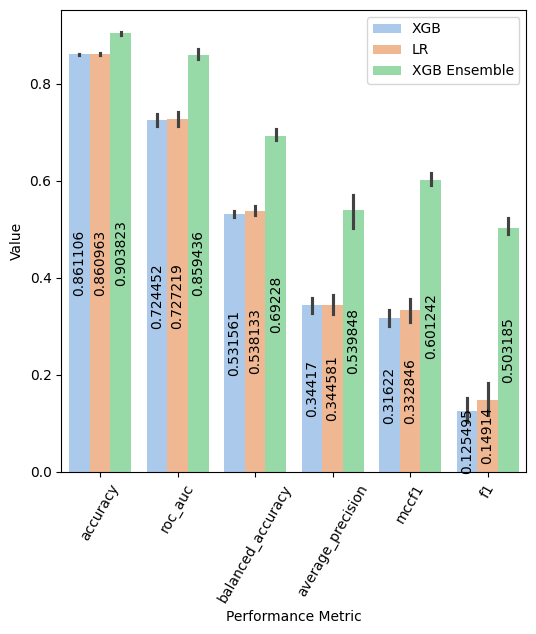

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6,6))
ax = sns.barplot(
    data=linePlotDf,
    x='Metric', y='Average AUROC Score',
    hue='Model',
    # labels=['1', '2','3'],
    palette=sns.color_palette("pastel"),
    errorbar=('ci', 95),
    )
for i in ax.containers:
    ax.bar_label(i, label_type='center', rotation=90)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['XGB', 'LR', 'XGB Ensemble'], loc="best")
ax.set(xlabel='Performance Metric')
ax.tick_params(axis='x', labelrotation=60)
ax.set(ylabel='Value')
# ax.set_title('Prediction performance comparison of XGB Ensemble with standalone models')
plt.show()